# <신장 종양 적출에 따른 손실체적(RAIV) 예측>

### 신장 종양 평가지표(PADUA, Renal..)를 활용한 최소한의 필요한 종양 적출 체적 예측
- 과거에는 신장에 발생한 악성종양을 제거할 때 한쪽 신장을 모두 제거하는 것이 문제가 없는 것으로 인식됐었으나, 최근에는 신장 한쪽을 제거한 경우 수술 후 신부전·심혈관질환 각종 대사성 질환의 빈도가 증가한다는 보고가 있어 가능하면 신장을 보존하는 것이 추천되는 경향
- 신장은 출혈 위험이 크며, 생명 유지에 중요한 기능을 하는 장기이므로  신장의 기능을 보존할 수 있게 신장 수술의 목표는 최소 절개 및 최대 보존
- 신장을 최대한 보존해 합병증을 줄임으로써 중요한 만성질환 예방과 삶의 질을 높여 환자들에게 큰 도움이 될 것

### 1. 데이터 불러오기

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [26]:
padua_data = pd.read_csv('./data/kideny_PADUA_upload.csv')
renal_data = pd.read_csv('./data/kideny_RENAL_upload.csv')
treat_data = pd.read_csv('./data/kidney_treat_upload.csv')

#### RENAL
- 'serial' : 환자번호
- 'Radius_RENAL' : 종양의 최장 반지름 길이(cm) -> T_size
- 'Exophytic_RENAL' : 종양의 외성장 정도(%) -> T_exophytic
- 'Nearness_RENAL' : 종양의 집배뇨관의 근접 정도 -> T_near_urethra
- 'APX_RENAL' : 종양의 위치 - 전/후방 -> T_APX
- 'Location_RENAL' : 종양의 집배뇨관 기준 상대 위치 -> T_rel_urethra
- 'RENAL_total' : 최종 RENAL 점수

In [ ]:
#### RENAL
- 'serial' : 환자번호
- 'RAIV_1' : 손실체적(cm^3)

### 2. 데이터 정리

- 중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기 

In [27]:
merged_data = pd.merge(padua_data, renal_data, on='serial')

In [28]:
merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1, inplace=True)

In [29]:
merged_result = pd.merge(merged_data, treat_data, on='serial')

- 컬럼명 변경

In [30]:
# RAIV_1 -> RAIV
merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_Exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_gm_over','Sinus_PADUA':'T_sinus_dt',
                            'Nearness_RENAL':'T_near_urethra','APX_RENAL':'T_APX','Location_RENAL':'T_rel_urethra','RAIV_1': 'RAIV'
                            }, inplace=True)

- 결측치 제거

In [31]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   serial          400 non-null    int64  
 1   T_surface_loc   395 non-null    float64
 2   T_sinus_dt      395 non-null    float64
 3   T_height_loc    395 non-null    float64
 4   T_gm_over       395 non-null    float64
 5   PADUA_total     400 non-null    int64  
 6   T_size          396 non-null    float64
 7   T_Exophytic     395 non-null    float64
 8   T_near_urethra  395 non-null    float64
 9   T_APX           394 non-null    float64
 10  T_rel_urethra   395 non-null    float64
 11  RENAL_total     400 non-null    int64  
 12  RAIV            397 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 40.8 KB


In [32]:
merged_result = merged_result.dropna()

In [33]:
# total 합쳐보기(PADUA_total + RENAL_total  = total)
merged_result['total'] = (merged_result['T_surface_loc'] + merged_result['T_sinus_dt']+merged_result['T_height_loc'] + 
                        merged_result['T_gm_over'] + merged_result['T_size'] + merged_result['T_Exophytic'] +
                        merged_result['T_near_urethra']+merged_result['T_APX'] + merged_result['T_rel_urethra'])

In [34]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_Exophytic']

In [35]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   serial          389 non-null    int64  
 1   T_surface_loc   389 non-null    float64
 2   T_sinus_dt      389 non-null    float64
 3   T_height_loc    389 non-null    float64
 4   T_gm_over       389 non-null    float64
 5   PADUA_total     389 non-null    int64  
 6   T_size          389 non-null    float64
 7   T_Exophytic     389 non-null    float64
 8   T_near_urethra  389 non-null    float64
 9   T_APX           389 non-null    float64
 10  T_rel_urethra   389 non-null    float64
 11  RENAL_total     389 non-null    int64  
 12  RAIV            389 non-null    float64
 13  total           389 non-null    float64
 14  T_size_exo      389 non-null    float64
dtypes: float64(12), int64(3)
memory usage: 48.6 KB


### 3. 데이터 탐색

In [36]:
merged_result.head()

,serial,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,PADUA_total,T_size,T_Exophytic,T_near_urethra,T_APX,T_rel_urethra,RENAL_total,RAIV,total,T_size_exo
0,1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1,12.0,3.0
1,2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1,14.0,3.0
2,3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8,10.0,2.0
3,4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7,16.0,2.0
4,5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8,13.0,3.0


In [37]:
merged_result.describe()

,serial,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,PADUA_total,T_size,T_Exophytic,T_near_urethra,T_APX,T_rel_urethra,RENAL_total,RAIV,total,T_size_exo
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,202.228792,1.354756,1.318766,1.398458,1.311054,8.460154,1.208226,1.868895,1.920308,1.557841,1.799486,4.989717,27.196144,13.737789,3.077121
std,116.730333,0.479055,0.466598,0.490211,0.485253,1.682714,0.471162,0.718521,0.906064,0.497283,0.806481,1.428682,24.330815,2.813468,0.811779
min,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.500000,9.000000,2.000000
25%,104.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,10.800000,12.000000,2.000000
50%,202.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,2.000000,2.000000,2.000000,2.000000,5.000000,19.000000,13.000000,3.000000
75%,299.000000,2.000000,2.000000,2.000000,2.000000,9.000000,1.000000,2.000000,3.000000,2.000000,2.000000,6.000000,35.100000,16.000000,4.000000
max,412.000000,2.000000,2.000000,2.000000,3.000000,13.000000,3.000000,3.000000,3.000000,2.000000,3.000000,8.000000,154.800000,21.000000,5.000000


In [38]:
# Raiv에 대한 histogram
import plotly.express as px

fig=px.histogram(merged_result, x='RAIV')
fig.show()

In [39]:
merged_result.describe()

,serial,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,PADUA_total,T_size,T_Exophytic,T_near_urethra,T_APX,T_rel_urethra,RENAL_total,RAIV,total,T_size_exo
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,202.228792,1.354756,1.318766,1.398458,1.311054,8.460154,1.208226,1.868895,1.920308,1.557841,1.799486,4.989717,27.196144,13.737789,3.077121
std,116.730333,0.479055,0.466598,0.490211,0.485253,1.682714,0.471162,0.718521,0.906064,0.497283,0.806481,1.428682,24.330815,2.813468,0.811779
min,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.500000,9.000000,2.000000
25%,104.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,10.800000,12.000000,2.000000
50%,202.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,2.000000,2.000000,2.000000,2.000000,5.000000,19.000000,13.000000,3.000000
75%,299.000000,2.000000,2.000000,2.000000,2.000000,9.000000,1.000000,2.000000,3.000000,2.000000,2.000000,6.000000,35.100000,16.000000,4.000000
max,412.000000,2.000000,2.000000,2.000000,3.000000,13.000000,3.000000,3.000000,3.000000,2.000000,3.000000,8.000000,154.800000,21.000000,5.000000


- 이상치 제거

In [40]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Box(y=merged_result['RAIV'], name='RAIV'))
fig.show()

- 상관관계

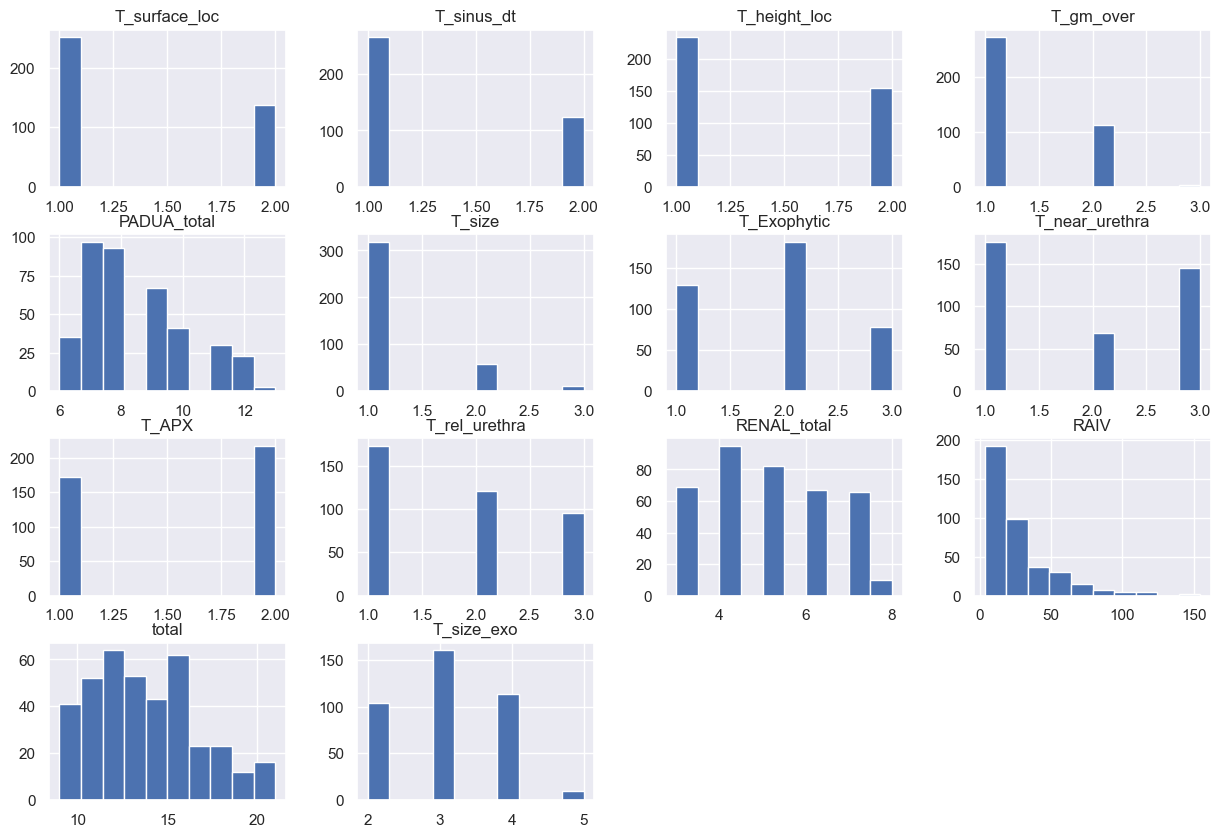

In [41]:
# 분포확인( 범주형 데이터 )
merged_corr = merged_result.drop(['serial'], axis=1)
merged_corr.hist(bins=10, figsize=(15,10))
plt.show()

<Axes: >

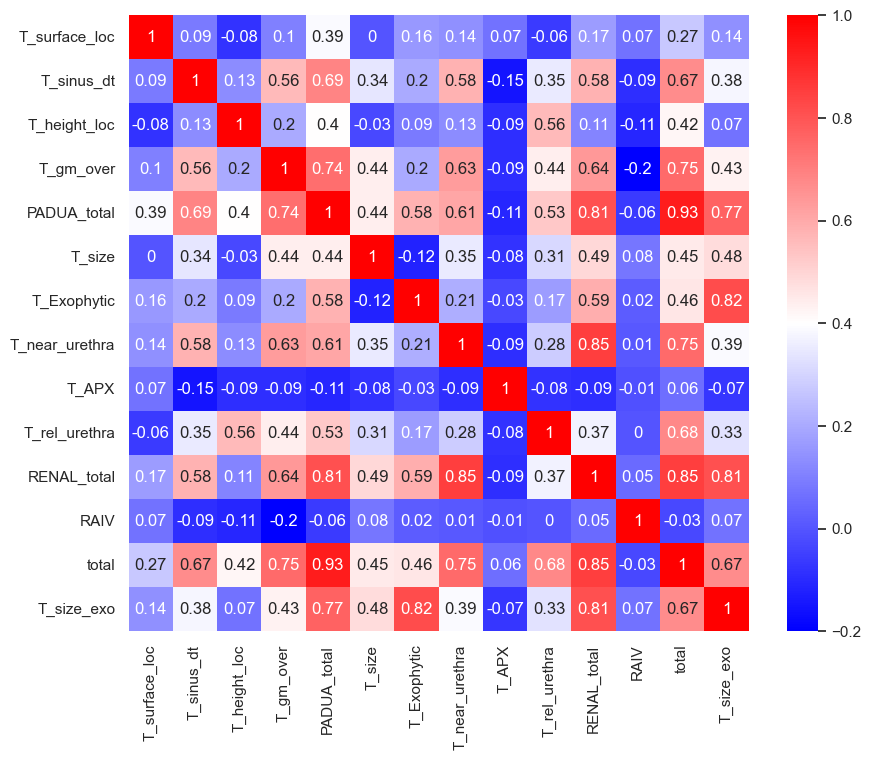

In [42]:
# corr() 함수이용해보기
corr = merged_corr.corr().round(2)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=corr, annot=True, cmap='bwr')

---

In [43]:
# T_size(종양 크기 	≤4 ; 4-7 ; 7)에 따른 Raiv 

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_size'], mode='markers', name='T_size', marker=dict(color=merged_result['T_size'])))
fig.show()


In [44]:
# T_Exophytic(외성장비율 ≥50 ; <50 ; e내장성ndophytic_)에 따른 Raiv

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_Exophytic'], mode='markers', name='T_Exophytic', marker=dict(color=merged_result['T_Exophytic'])))
fig.show()

- 종양이 작거나 신장의 표면으로 많이 튀어나와 있는 형태는 신장부분절제수술이 비교적 용이하지만 
- 종양의 크기가 크거나, 위치가 좋지 않거나 신장 내에 파묻혀 있는 경우에는 ‘신장 부분절제술’이 기술적 어려움, 합병증 초래 -> 신장 전체 적출술을 선택하게 되는 경우가 많다.
(-> 로봇수술로 신장 전절제술이 필요한 ‘내장성 신장암’ 환자를 부분절제술로 치료하는 경우도 있음)
- 신장 안쪽에 파묻혀 있고 종양의 크기가 4cm 이상인 경우에는 신장 부분 절제술의 이득이 없어 신장 전체 절제술을 권장

In [45]:
# T_size_exo에 따른 Raiv ((T_size + T_Exophytic = T_size_exo ))

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_size_exo'], mode='markers', name='T_size_exo', marker=dict(color=merged_result['T_size_exo'])))
fig.show()

In [46]:
# T_surface_loc (종양의 표면 위치 lateral_외측 ; Medial_내측(몸 중심 가까이))에 따른 Raiv

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_surface_loc'], mode='markers', name='T_surface_loc', marker=dict(color=merged_result['T_surface_loc'])))
fig.show()

In [47]:
# EDA 더 할거? 추가 플러스

---

### 3. 데이터 나누기

In [48]:
from sklearn.model_selection import train_test_split

X = merged_result.drop(['RAIV','serial'], axis=1)  # 'RAIV_1' 열을 제외한 모든 열 선택
y = merged_result['RAIV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# def함수 (MAE, RMSE)

### 4. 군집이용

In [50]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cluster_range = range(2, 11)

optimal_clusters = 0
max_silhouette_score = -1

for n_clusters in cluster_range:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    kmeans.fit(X_train)
    
    clusters = kmeans.predict(X_train)
    
    silhouette_avg = silhouette_score(X_train, clusters)
    
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_clusters = n_clusters

# Print the optimal number of clusters
print("Optimal number of clusters:", optimal_clusters)

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte
c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\joblib\externals\loky\back

Optimal number of clusters: 2


In [51]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# 학습된 모델을 이용하여 train 데이터에 대한 군집 레이블 예측
train_cluster_labels = kmeans.predict(X_train)

# 학습된 모델을 이용하여 test 데이터에 대한 군집 레이블 예측
test_cluster_labels = kmeans.predict(X_test)

print('train_cluster_labels :', train_cluster_labels)
print('test_cluster_labels : ', test_cluster_labels)

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



train_cluster_labels : [0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1
 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0
 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0]
test_cluster_labels :  [1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1
 1 0 0 1]


In [52]:
X_tr_1 = X_train[train_cluster_labels == 1]
X_test_1 = X_test[test_cluster_labels == 1]
y_tr_1 = y_train[train_cluster_labels == 1]
y_test_1 = y_test[test_cluster_labels == 1]

X_tr_0 = X_train[train_cluster_labels == 0]
X_test_0 = X_test[test_cluster_labels == 0]
y_tr_0 = y_train[train_cluster_labels == 0]
y_test_0 = y_test[test_cluster_labels == 0]

In [53]:
count_train_cluster_0 = len(X_tr_0)
count_train_cluster_1 = len(X_tr_1)
count_test_cluster_0 = len(X_test_0)
count_test_cluster_1 = len(X_test_1)

import plotly.graph_objects as go

# Plotly를 사용하여 시각화
fig = go.Figure()

# 훈련 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_0.iloc[:], mode='markers', marker=dict(color='blue'), name='Train Cluster 0'))

# 훈련 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_1.iloc[:], mode='markers', marker=dict(color='red'), name='Train Cluster 1'))

# 테스트 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_0.iloc[:], mode='markers', marker=dict(color='green'), name='Test Cluster 0'))

# 테스트 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_1.iloc[:], mode='markers', marker=dict(color='orange'), name='Test Cluster 1'))

fig.show()